In [1]:
%matplotlib notebook
import os
import os.path as path
import pandas as pd
import h5py
import numpy as np
from faker import Factory
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *
import plotly
import ipywidgets as widgets

# Local module and scripts
from pyccapt.calibration.calibration_tools import data_tools, variables, tools, reconstruction
from pyccapt.calibration.calibration_tools import reconstruction
from pyccapt.calibration.calibration_tools import widgets as wd


In [2]:
save_fig=False
plot_fig=True 

In [3]:
# flightPathLength = 110 # mm 
# # The initial value for t_0
# t0 = 51.74 # ns

# dataset name
# AL_data_b
# OLO_AL_6_data
# OLO_W_6_data
# OLO_Ni_8_data
# X6Cr17_2V30Min_5_data
# data_1029_Jun-27-2022_15-53_Pd
# data_115_Jul-27-2022_17-44_Powersweep3

In [4]:
tdc, dataset, flightPathLength_d, t0_d = wd.dataset_tdc_selection()
display(tdc, dataset, flightPathLength_d, t0_d)

Dropdown(description='TDC model:', options=('surface_concept', 'roentdec'), value='surface_concept')

Text(value='OLO_AL_6_data', description='Dataset:', placeholder='Paste ticket description here!')

Text(value='110', description='Flight path length:', placeholder='Flight path length')

Text(value='51.74', description='t0:', placeholder='T_0 of the instrument')

$$\textbf{You can specify which dataset to use in below block}$$

In [5]:
tdc_model = tdc.value

dataset_name = dataset.value

flightPathLength = float(flightPathLength_d.value) # mm 
# The initial value for t_0
t0 = float(t0_d.value) # ns

p = path.abspath(path.join("", "../../../.."))

variables.init()

path_main = os.path.join(p, 'tests//data')
filename_main = path_main + '//' + dataset_name + '.h5'

variables.path = os.path.join(p, 'tests//results//load_crop')
variables.result_path = os.path.join(p, 'tests/results/reconstruction/' + dataset_name)
if not os.path.isdir(variables.result_path):
        os.makedirs(variables.result_path, mode=0o777, exist_ok=True)
        
filename = variables.path + '//' + dataset_name + '//' + dataset_name + '_cropped' + '.h5'



head, tail = os.path.split(filename)
figname = os.path.splitext(tail)[0]

data = data_tools.read_hdf5_through_pandas(filename)


dld_highVoltage = data['dld/high_voltage'].to_numpy()
dld_pulseVoltage = data['dld/pulse_voltage'].to_numpy()
dld_t = data['dld/t'].to_numpy()
dld_x = data['dld/x'].to_numpy()
dld_y = data['dld/y'].to_numpy()

In [6]:
data

,dld/high_voltage,dld/pulse_voltage,dld/start_counter,dld/t,dld/x,dld/y
0,5261.248047,5261.248047,9299.0,634.893066,5.985306,-22.763265
1,5261.248047,5261.248047,9551.0,467.893908,-3.629388,17.032653
2,5261.248047,5261.248047,10161.0,649.486890,-17.828571,23.973061
3,5261.248047,5261.248047,10358.0,646.016742,19.038367,20.980408
4,5261.248047,5261.248047,10581.0,632.588778,22.476735,-6.176327
...,...,...,...,...,...,...
1822981,5708.472656,5708.472656,26372.0,618.042960,-19.993469,-22.922449
1822982,5708.472656,5708.472656,26455.0,612.954324,13.180408,18.751837
1822983,5708.472656,5708.472656,26564.0,453.642984,-8.309388,20.725714
1822984,5708.472656,5708.472656,26777.0,605.561400,18.274286,11.111020


In [7]:
# t0
dld_t = dld_t - t0

In [8]:
# Remove negative and zero TOF
threshold = 70
dld_highVoltage = dld_highVoltage[dld_t>threshold]
dld_pulseVoltage = dld_pulseVoltage[dld_t>threshold]
dld_x = dld_x[dld_t>threshold]
dld_y = dld_y[dld_t>threshold]
dld_t = dld_t[dld_t>threshold]

In [9]:
mc_oxcart = np.array(pd.DataFrame(np.array(h5py.File(filename)['cropped_dld']['mc'])))

09-23-2022 13:30:35 | INFO | Selected Mode = count
09-23-2022 13:30:35 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


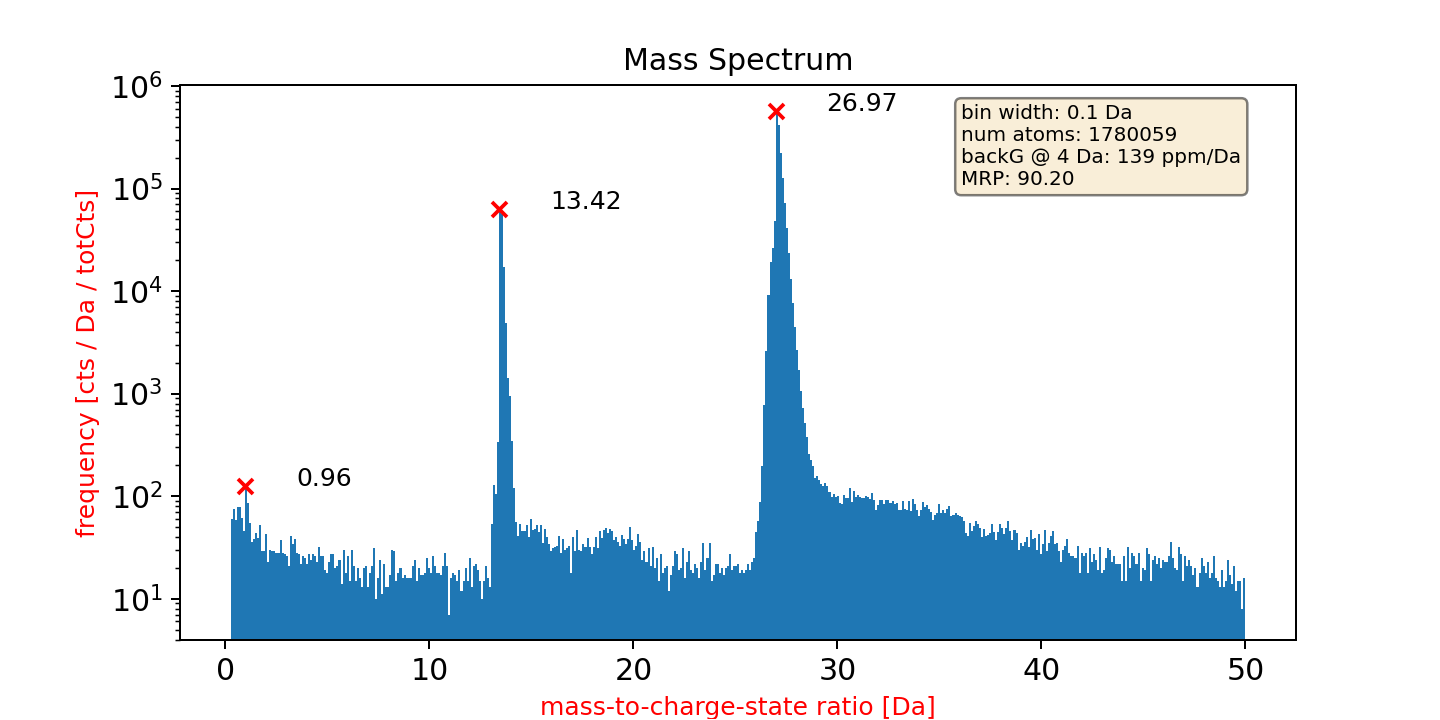

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): [90.19830384]
Peaks  0 is: 0.96 peak window sides are: 0.86 - 1.16
Peaks  1 is: 13.42 peak window sides are: 13.32 - 13.62
Peaks  2 is: 26.97 peak window sides are: 26.87 - 27.17


In [10]:
max_hist_p, left_right_peaks_p, peaks_sides_p, max_paek_edges_p, index_max_p = tools.massSpecPlot(mc_oxcart[mc_oxcart < 50], 0.1, prominence=40, distance=2, text_loc='right', percent=50, plot=True, fig_name='oxcart_mc'+figname)
mrp = (max_hist_p / (left_right_peaks_p[1] - left_right_peaks_p[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
peak_list = []
for i in range(len(peaks_sides_p)):
    peak_list.append(peaks_sides_p[i,0])
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides_p[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides_p[i,2], peaks_sides_p[i,3]))

In [111]:
def atom_probe_recons_bas_et_al(detx, dety, hv, flight_path_length, kf, det_eff, icf, field_evap, avg_dens):
    """
    :param detx: Hit position on the detector
    :param dety: Hit position on the detector
    :param hv: High voltage
    :param kf: Field reduction factor
    :param icf: Image compression factor Because sample is not a perfect sphere
    :param flight_path_length: distance between detector and sample
    :param ion_volume: atomic volume in atoms/nm ^ 3
    :param det_eff: Efficiency of the detector
    :return:
    """
    # f_evap   evaporation field in V / nm
    radius_evolution = hv / (icf * (field_evap / 1E-9))

    m = (flight_path_length * 1E-3) / (kf * radius_evolution)

    x = (detx * 1E-3) / m
    y = (dety * 1E-3) / m

    # detector coordinates in polar form
    rad, ang = reconstruction.cart2pol(detx * 1E-3, dety * 1E-3)
    # calculating effective detector area:
    det_area = (np.max(rad) ** 2) * np.pi
    
    # accumulative part of z
    omega = 1E-9 ** 3 / avg_dens  # atomic volume in nm ^ 3

#     dz = ((omega * (110 * 1E-3)**2) / (det_area * det_eff * (icf ** 2) * (radius_evolution ** 2))

    dz = (omega * ((flight_path_length * 1E-3)**2) * (kf**2) * ((field_evap/1E-9)**2)) / (det_area * det_eff * (icf**2) * (hv**2))
          
#     dz_p = radius_evolution * (1 - np.sqrt((x**2 + y**2) / (radius_evolution**2)))
    dz_p =  radius_evolution * (1 - np.sqrt(1- ((x**2 + y**2) / (radius_evolution**2))))
#     dz_p = radius_evolution - np.sqrt((x**2) + (y**2))
    
    z = np.cumsum(dz) + dz_p

    return x*1E9, y*1E9, z*1E9

In [129]:
def atom_probe_recons_from_detector(detx, dety, hv, flight_path_length, kf, det_eff, icf, field_evap, avg_dens):
    """
    # atom probe reconstruction after: Gault et al., Ultramicroscopy 111(2011) 448 - 457
    x, y are the detector hit coordinates in mm
    kf is the field factor and ICF is the image compression factor
    :param detx:
    :param dety:
    :param hv:
    :param kf:
    :param icf:
    :param flight_path_length:
    :param ion_volume:
    :param det_eff:
    :param radius_evolution:
    :return:
    """

    ## constants and variable setup
    # specimen parameters
    # avgDens # atomic density in atoms / nm3
    # Fevap  # evaporation field in V / nm

    # detector coordinates in polar form
    rad, ang = reconstruction.cart2pol(detx * 1E-3, dety * 1E-3)
    # calculating effective detector area:
    det_area = (np.max(rad) ** 2) * np.pi
    # f_evap   evaporation field in V / nm
    radius_evolution = hv / (kf * (field_evap / 1E-9))

    #m = (flight_path_length * 1E-3) / (kf * radius_evolution)

    # launch angle relative to specimen axis
    theta_p = np.arctan(rad / (flight_path_length * 1E-3))  # mm / mm
    
    thet_a = theta_p + np.arcsin((kf - 1) * np.sin(theta_p))
    
    icf_2 = thet_a / theta_p

    # distance from axis and z shift of each hit
    z_p, d = reconstruction.pol2cart(radius_evolution, thet_a)  # nm

    # x and y coordinates from the angle on the detector and the distance to
    # the specimen axis.
    x, y = reconstruction.pol2cart(d, ang)  # nm

    ## calculate z coordinate
    # the z shift with respect to the top of the cap is Rspec - zP
    z_p = radius_evolution - z_p

    # accumulative part of z
    omega = 1E-9 ** 3 / avg_dens  # atomic volume in nm ^ 3

    # nm ^ 3 * mm ^ 2 * V ^ 2 / nm ^ 2 / (mm ^ 2 * V ^ 2)
#     dz = omega * ((flight_path_length * 1E-3) ** 2) * (kf ** 2)  / (det_eff * det_area * (icf ** 2)) * (
#                 hv ** 2)
    dz = (omega * ((flight_path_length * 1E-3)**2) * (kf**2) * ((field_evap/1E-9)**2)) / (det_area * det_eff * (icf_2**2) * (hv**2))
    # wide angle correction
    cum_z = np.cumsum(dz)
    z = cum_z + z_p

    return x * 1E9, y * 1E9, z * 1E9

In [133]:
element = wd.density_field_selection()
display(element)

Dropdown(description='Element', options=((1, 'H', 52.7, 0.0), (2, 'He', 28.7, 0.0), (3, 'Li', 46.3, 14.0), (4,…

In [134]:
avg_dens = widgets.FloatText(
    value=element.value[2],
    description='Desnsity:',
    disabled=False
)
field_evap = widgets.FloatText(
    value=element.value[3],
    description='Filed_Evap:',
    disabled=False
)
kf = widgets.FloatText(
    value=4,
    description='K_f:',
    disabled=False
)
det_eff = widgets.FloatText(
    value=0.5,
    description='det_eff:',
    disabled=False
)
icf = widgets.FloatText(
    value=1.4,
    description='ICF:',
    disabled=False
)
flight_path_length = widgets.FloatText(
    value=110,
    description='Flight_path_lenght:',
    disabled=False
)
display(avg_dens, field_evap, kf, det_eff, icf, flight_path_length)

FloatText(value=60.2, description='Desnsity:')

FloatText(value=19.0, description='Filed_Evap:')

FloatText(value=4.0, description='K_f:')

FloatText(value=0.5, description='det_eff:')

FloatText(value=1.4, description='ICF:')

FloatText(value=110.0, description='Flight_path_lenght:')

In [130]:
px, py, pz = atom_probe_recons_from_detector(dld_x, dld_y, dld_highVoltage, flight_path_length=flight_path_length.value, kf=kf.value, det_eff=det_eff.value, icf=icf.value, field_evap=field_evap.value, avg_dens=60.2)

C:\Users\APTUser\AppData\Local\Temp\ipykernel_44764\994044470.py:37: RuntimeWarning:

invalid value encountered in true_divide



In [112]:
px, py, pz = atom_probe_recons_bas_et_al(dld_x, dld_y, dld_highVoltage, flight_path_length=flight_path_length.value, kf=kf.value, det_eff=det_eff.value, icf=icf.value, field_evap=field_evap.value, avg_dens=60.2)

C:\Users\APTUser\AppData\Local\Temp\ipykernel_44764\2096352123.py:34: RuntimeWarning:

invalid value encountered in sqrt



In [33]:
peak_list

[0.9563990338286599, 13.416115729502872, 26.972287494396415]

In [34]:
# phases = ['H1(+)', 'H2(+)', '5.13', '8.76', 'P(3+)', 'C12(+)', '12.49', 'C13(+)', '13.47', 'Si28(+)', '22.89', '23.87', 'Cr50(2+)', 'Cr52(2+)']
# colors = ['#ab2020', '#224d90', '#47684c', '#e2e14c', '#0492c2', '#7ea1ad', '#8b324d', '#7b7cf8', '#74632b', '#eed5b7', '#0c2aac', '#50ffd6', '#c9f2c9','#99c35f']
phases = ['H1(+)', 'Al(2+)', 'Al(+)' ]
colors = ['#ab2020', '#224d90', '#47684c']

In [131]:
fake = Factory.create()
plotly_data = list()
max_plot = 0.02
for index, element in enumerate(phases):
    mask = np.logical_and((peaks_sides_p[index,2] < mc_oxcart), (mc_oxcart < peaks_sides_p[index,3])).squeeze()
    print(mask[mask==True].shape)
    # to reduce the number of ions to plot base on the input maxplot percent
    index_true = np.where(mask==True)
    index_get_to_false = np.random.choice(index_true[0], size=int(index_true[0].shape[0] - index_true[0].shape[0]*max_plot), replace=False)
    mask[index_get_to_false] = False
    print('ploted ions',mask[mask==True].shape)
    
    scatter = dict(
        mode="markers",
        name=element,
        type="scatter3d",
        x=px[mask], y=py[mask], z=pz[mask],
        opacity = 0.2,
        marker = dict(size=2, color=colors[index]) #fake.hex_color()
    )
    plotly_data.append(scatter)

layout = dict(
    title = 'APT 3D Point Cloud',
    scene = dict(xaxis = dict(zeroline=False, title='x (nm)'),
                yaxis = dict(zeroline=False, title='y (nm)'),
                zaxis = dict(zeroline=False, title='z (nm)', autorange='reversed'))
)

fig = dict(data=plotly_data, layout=layout)

init_notebook_mode(connected=True)  
# plotly.offline.plot(fig, filename=variables.result_path + '\\{fn}.html'.format(fn=figname), show_link=False)
iplot(fig)

(259,)
ploted ions (6,)
(120791,)
ploted ions (2416,)
(1042016,)
ploted ions (20841,)


In [ ]:
ax = plt.figure().add_subplot(111)
for element in phases:
    ax.scatter(py, pz, s=2, label=element)
ax.xaxis.tick_top()
ax.invert_yaxis()
ax.set_xlabel('Y (nm)')
ax.xaxis.set_label_position('top')
ax.set_ylabel('Z (nm)')
plt.legend()
plt.savefig(variables.result_path + '\\output_{fn}.png'.format(fn=figname))

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

mask = np.random.randint(0, len(px), 300)

ax.scatter(px[mask], py[mask], pz[mask])
ax.set_xlabel('X (nm)')
ax.set_ylabel('Y (nm)')
ax.set_zlabel('Z (nm)')

plt.show()